## Vehicle Detection

In [5]:
import numpy as np
import pandas as pd
import cv2
import glob

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure

from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from lesson_functions import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/home/alpernkanli/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First of all, before everything, the training images are read:

In [6]:
nonvehicles = pd.DataFrame(glob.glob('./non-vehicles/*/*.png'), columns=['image'])
nonvehicles['label'] = 0

vehicles = pd.DataFrame(glob.glob('./vehicles/*/*.png'), columns=['image'])
vehicles['label'] = 1

In [7]:
print('Number of vehicle samples is:')
print(vehicles['image'].shape[0])
print('Number of nonvehicle samples is: ')
print(nonvehicles['image'].shape[0])
print('Shape of an image is:')
print(mpimg.imread(vehicles['image'].iloc[0]).shape)

Number of vehicle samples is:
8792
Number of nonvehicle samples is: 
8968
Shape of an image is:
(64, 64, 3)


And two examples (one for vehicle samples, one for non-vehicle samples) are read:

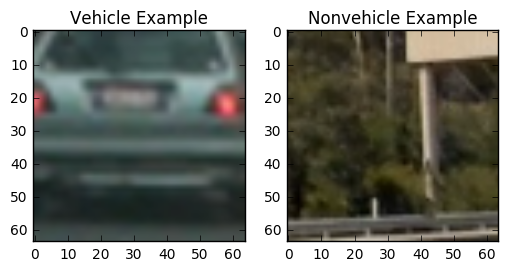

In [8]:
vehicle_sample = mpimg.imread(vehicles['image'].iloc[400])
nonvehicle_sample = mpimg.imread(nonvehicles['image'].iloc[400])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(vehicle_sample)
ax1.set_title('Vehicle Example')
ax2.imshow(nonvehicle_sample)
ax2.set_title('Nonvehicle Example')

And a container class for parameters is defined:

In [9]:
class Parameters:
    def __init__(self):
        # The default values are initialized:
        self.color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (32, 32) # Spatial binning dimensions
        self.hist_bins = 32   # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.vis = True
        
        # Start and stop points of the sliding window search:
        self.ystart = 400
        self.ystop = 660
        # Sliding window size (it is a square)
        self.window_size = 64
        # Scaling of the image of interest in sliding window search
        self.scale = 1.4
        # Cell per step to slide window
        self.cell_per_step = 1

In [10]:
parameters = Parameters()

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

A helper function named "get_hog_features" is used for extracting HOG features:

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

And here is an example of the hog image output for a vehicle and a nonvehicle image, for each color channel:

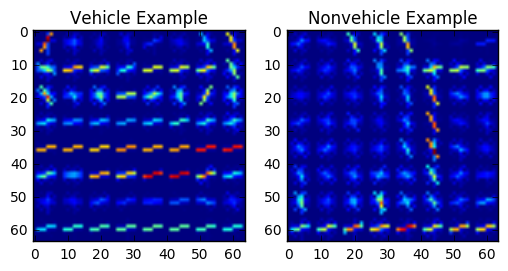

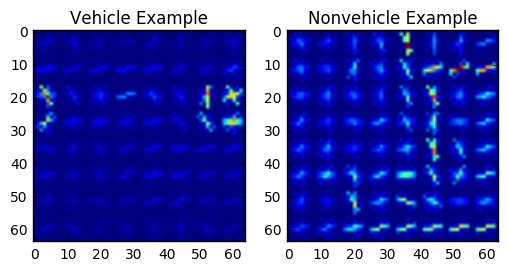

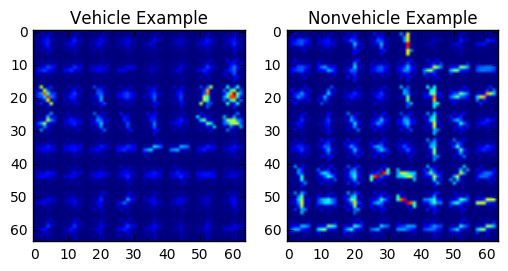

In [12]:
vehicle_sample = cv2.cvtColor(vehicle_sample, cv2.COLOR_RGB2YCrCb)
nonvehicle_sample = cv2.cvtColor(nonvehicle_sample, cv2.COLOR_RGB2YCrCb)

for channel in range(0, 3):
    _, vehicle_hog = get_hog_features(vehicle_sample[:,:,channel], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, vis=parameters.vis)
    _, nonvehicle_hog = get_hog_features(nonvehicle_sample[:,:,channel], parameters.orient, parameters.pix_per_cell, parameters.cell_per_block, vis=parameters.vis)

    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(vehicle_hog)
    ax1.set_title('Vehicle Example')
    ax2.imshow(nonvehicle_hog)
    ax2.set_title('Nonvehicle Example')

#### 2. Explain how you settled on your final choice of HOG parameters.

I experimented with many different color spaces and channels, and I am ended up with the YCrCb color space.

HSV was a good candidate too, but with YCrCb, I had a slightly better performance on the video.

Also, I experimented on the isolated channels of YCrCb for increasing the speed (i.e. decreasing the feature size), but it was not satisfying in terms of detection vehicles. For example, Y channel was good at a bluish white car, but Cr channel was good at a red car (as expected).

Also, I experimented with the isolated S channel of HSV images, but the result was not as satisfying as YCrCb.

In orientations and pixels per cell, I tried various options between certain ranges (6 to 10 for orientations, for example) and decided that 9 orientations and 8x8 pixel per cell was of the optimal result, as it is intuitively plausible considering the size of the images.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I used spatial bins and color histograms together with the HOG features.

The helper functions for extracting these features are below:

In [13]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Here, the features (HOG, spatial, histogram) are extracted from the data:

In [14]:
car_features = extract_features(vehicles['image'], color_space=parameters.color_space, 
                        spatial_size=parameters.spatial_size, hist_bins=parameters.hist_bins, 
                        orient=parameters.orient, pix_per_cell=parameters.pix_per_cell, 
                        cell_per_block=parameters.cell_per_block, 
                        hog_channel=parameters.hog_channel, spatial_feat=parameters.spatial_feat, 
                        hist_feat=parameters.hist_feat, hog_feat=parameters.hog_feat)
notcar_features = extract_features(nonvehicles['image'], color_space=parameters.color_space, 
                        spatial_size=parameters.spatial_size, hist_bins=parameters.hist_bins, 
                        orient=parameters.orient, pix_per_cell=parameters.pix_per_cell, 
                        cell_per_block=parameters.cell_per_block, 
                        hog_channel=parameters.hog_channel, spatial_feat=parameters.spatial_feat, 
                        hist_feat=parameters.hist_feat, hog_feat=parameters.hog_feat)

The vehicle and nonvehicle features are stacked together and scaled:

In [15]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

Also, their labels (1 for vehicles, 0 for nonvehicles) are stacked:

In [16]:
y = np.hstack((vehicles['label'], nonvehicles['label']))

Both shuffling and train-test splitting is made by using sklearn's train_test_split function:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

As the support vector classifier, LinearSVC() is used since using SVC witf 'rbf' didn't improve the performance so much, and considering its large difference in terms of speed, LinearSVC() is decided to be used.

In [18]:
svc = LinearSVC()

svc.fit(X_train, y_train)

accuracy = svc.score(X_test, y_test)
print("Accuracy of the support vector classifier is: ", accuracy)

Accuracy of the support vector classifier is:  0.992117117117


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

The helper functions for sliding windows and searching in windows are below:

In the cell below, two functions slide_and_search and extract_window_features are presented. The slide_and_search function:
    - Initializes an empty heatmap
    - Defines block sizes and block steps (window steps)
    - Creates a windowed image (in the shape of training images)
    - Calls extract_window_features function with windowed_image and necessary parameters.

Inside the extract_window_features:
    - Precomputed hog channels (precomputed for the whole image, because taking hog features of windows separately makes the algorithm incredibly slow) are sliced to get hog feature vector relevant to the window of image.
    - Spatial and histogram features are also extracted, and they are stack together with the hog features.
    - Since the same scaling on the training phase is required on the inference stage also, features are scaled.
    - By using features, a prediction is made (car or noncar)
    - If the prediction is 1 (car), a rectangle is drawn (with a correct scale) and heatmap is updated.

In [35]:
print(parameters.hog_channel)
print(parameters.color_space)

ALL
YCrCb


In [29]:
def slide_and_search(image_to_search, draw_image, hog_all, false_positive_rejection):
    heatmap = np.zeros_like(draw_image[:,:,0]).astype(np.float32)
    nxblocks = (image_to_search.shape[1] // parameters.pix_per_cell) - 1
    nyblocks = (image_to_search.shape[0] // parameters.pix_per_cell) - 1
    block_per_window = (parameters.window_size // parameters.pix_per_cell) - 1
    
    nxsteps = np.int((nxblocks - block_per_window) // parameters.cell_per_step)
    nysteps = np.int((nyblocks - block_per_window) // parameters.cell_per_step)
    
    for xstep in range(nxsteps):
        for ystep in range(nysteps):
            ypos = ystep*parameters.cell_per_step
            xpos = xstep*parameters.cell_per_step
            xleft = xpos*parameters.pix_per_cell
            ytop = ypos*parameters.pix_per_cell
            windowed_image = cv2.resize(image_to_search[ytop:ytop+parameters.window_size, xleft:xleft+parameters.window_size], (64, 64))
            
            extract_window_features(draw_image, windowed_image, block_per_window, hog_all, ypos, xpos, xleft, ytop, heatmap, false_positive_rejection)
    
    return draw_image, heatmap
    
    
def extract_window_features(draw_image, windowed_image, block_per_window, hog_all, ypos, xpos, xleft, ytop, heatmap, false_positive_rejection):

    hog_ch0 = hog_all[0]
    hog_ch1 = hog_all[1]
    hog_ch2 = hog_all[2]
    hog_feat0 = hog_ch0[ypos:ypos + block_per_window, xpos:xpos + block_per_window].ravel()
    hog_feat1 = hog_ch1[ypos:ypos + block_per_window, xpos:xpos + block_per_window].ravel()
    hog_feat2 = hog_ch2[ypos:ypos + block_per_window, xpos:xpos + block_per_window].ravel()
    
    features = np.hstack((hog_feat0, hog_feat1, hog_feat2))
    if parameters.spatial_feat == True:
        spatial_features = bin_spatial(windowed_image, size=parameters.spatial_size)
        features = np.hstack((features, spatial_features))
    if parameters.hist_feat == True:
        hist_features = color_hist(windowed_image, nbins=parameters.hist_bins)
        features = np.hstack((features, hist_features))
    
    features = features.reshape(1, -1)
    test_features = X_scaler.transform(features)
    test_prediction = svc.predict(test_features)
    
    if test_prediction == 1:
        xbox_left = np.int(xleft*parameters.scale)
        ytop_draw = np.int(ytop*parameters.scale)
        win_draw = np.int(parameters.window_size*parameters.scale)
        box = [(xbox_left, ytop_draw + parameters.ystart), (xbox_left + win_draw, ytop_draw + win_draw + parameters.ystart)]
        cv2.rectangle(draw_image, box[0], box[1],
                      (0, 0, 255), 6)
        if false_positive_rejection:
            add_heat(heatmap, box)

Here is the single image pipeline:

In [30]:
def pipeline(image, false_positive_rejection):
    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    image_to_search = image[parameters.ystart:parameters.ystop,:,:]
    if parameters.color_space != 'RGB':
        if parameters.color_space == 'HSV':
            image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2HSV)
        elif parameters.color_space == 'LUV':
            image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2LUV)
        elif parameters.color_space == 'HLS':
            image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2HLS)
        elif parameters.color_space == 'YUV':
            image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2YUV)
        elif parameters.color_space == 'YCrCb':
            image_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2YCrCb)
    
    if parameters.scale != 1:
        imshape = image_to_search.shape
        image_to_search = cv2.resize(image_to_search, (np.int(imshape[1] / parameters.scale), np.int(imshape[0] / parameters.scale)))
    
    if parameters.hog_channel == 'ALL':
        hog_all = []
        for channel in range(0, 3):
            hog_all.append(get_hog_features(image_to_search[:,:,channel], parameters.orient, 
                                            parameters.pix_per_cell, parameters.cell_per_block, 
                                            feature_vec=False))
    else:
        hog_all = get_hog_features(image_to_search[:,:,parameters.hog_channel], parameters.orient, 
                                            parameters.pix_per_cell, parameters.cell_per_block, 
                                            feature_vec=False)
        
    draw_image, heatmap = slide_and_search(image_to_search, draw_image, hog_all, false_positive_rejection)
    
    return draw_image, heatmap

Helper function for visualizing multiple images in a cell:

In [31]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

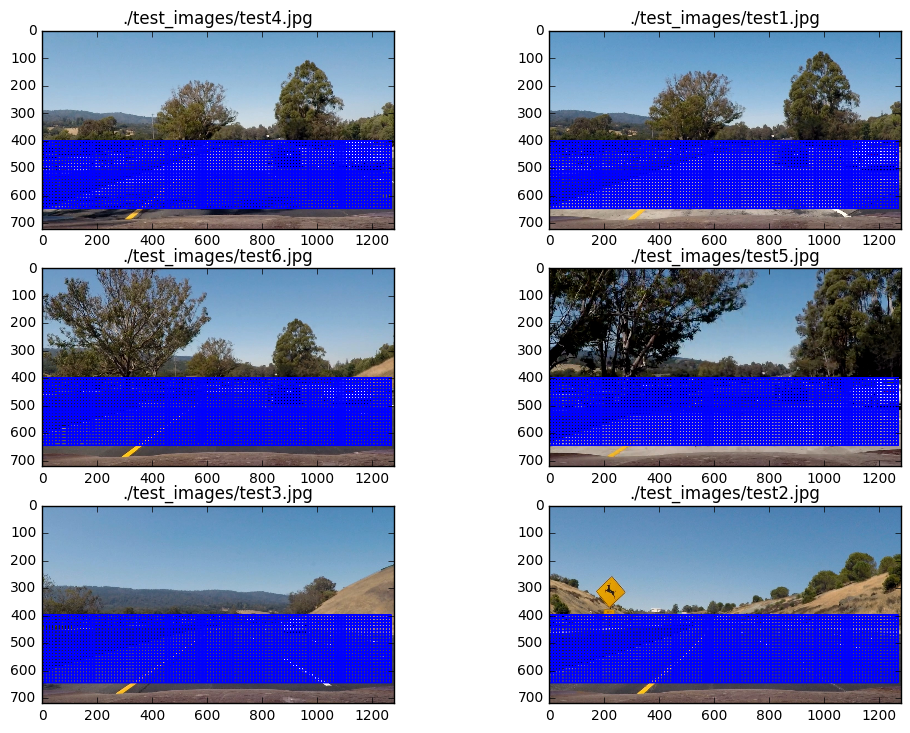

In [32]:
out_images = []
out_titles = []
heatmaps = []
search_path = './test_images/*'
test_images = glob.glob(search_path)
for img_path in test_images:
    image = mpimg.imread(img_path)
    out_img, heat_map = pipeline(image, false_positive_rejection=False)
    out_images.append(out_img)
    out_titles.append(img_path)
    heatmaps.append(heat_map)
image_figure = plt.figure(figsize=(12, 24))
visualize(image_figure, 8, 2, out_images, out_titles)

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./output1.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In [23]:
def add_heat(heatmap, box):
    # for box in bbox_list:
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

In [24]:
out_images = []
out_titles = []
heatmaps = []
labelmaps = []
search_path = './test_images/*'
test_images = glob.glob(search_path)
for img_path in test_images:
    image = mpimg.imread(img_path)
    out_img, heat_map = pipeline(image)
    unthresholded_heat_map = heat_map
    heat_map = apply_threshold(heat_map, 2)
    labels = label(heat_map)
    out_img, box = draw_labeled_bboxes(np.copy(image), labels)
    out_images.append(out_img)
    out_titles.append(img_path)
    heatmaps.append(unthresholded_heat_map)
    labelmaps.append(labels[0])
image_figure = plt.figure(figsize=(12, 24))
visualize(image_figure, 8, 2, out_images, out_titles)

TypeError: pipeline() missing 1 required positional argument: 'false_positive_rejection'

Even a car on the other road is detected in the image test1.jpg!

And now, the corresponding unthresholded heatmaps:

In [ ]:
heatmap_figure = plt.figure(figsize=(12, 24))
visualize(heatmap_figure, 8, 2, heatmaps, out_titles)

And this is the label map of the heat map:

In [ ]:
labelmap_figure = plt.figure(figsize=(12, 24))
visualize(image_figure, 8, 2, labelmaps, out_titles)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_frame(image):
    out_img, heat_map = pipeline(image)
    heat_map = apply_threshold(heat_map, 2)
    labels = label(heat_map)
    out_img, box = draw_labeled_bboxes(np.copy(image), labels)
    return out_img

In [ ]:
video_output = "output1.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))